<a href="https://colab.research.google.com/github/kandukooriniharika/project_management_tools/blob/main/ENSEMBLE%20LEARNING%20FOR%20HEALTH%20INSURANCE%20COST%20PREDICTION%20AND%20ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset
data = pd.read_csv("/content/insurance.csv")

# Display first 5 rows
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Encoding categorical variables
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])
data['region'] = label_encoder.fit_transform(data['region'])

# Define Features (X) and Target (y)
X = data.drop(columns=['charges'])
y = data['charges']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

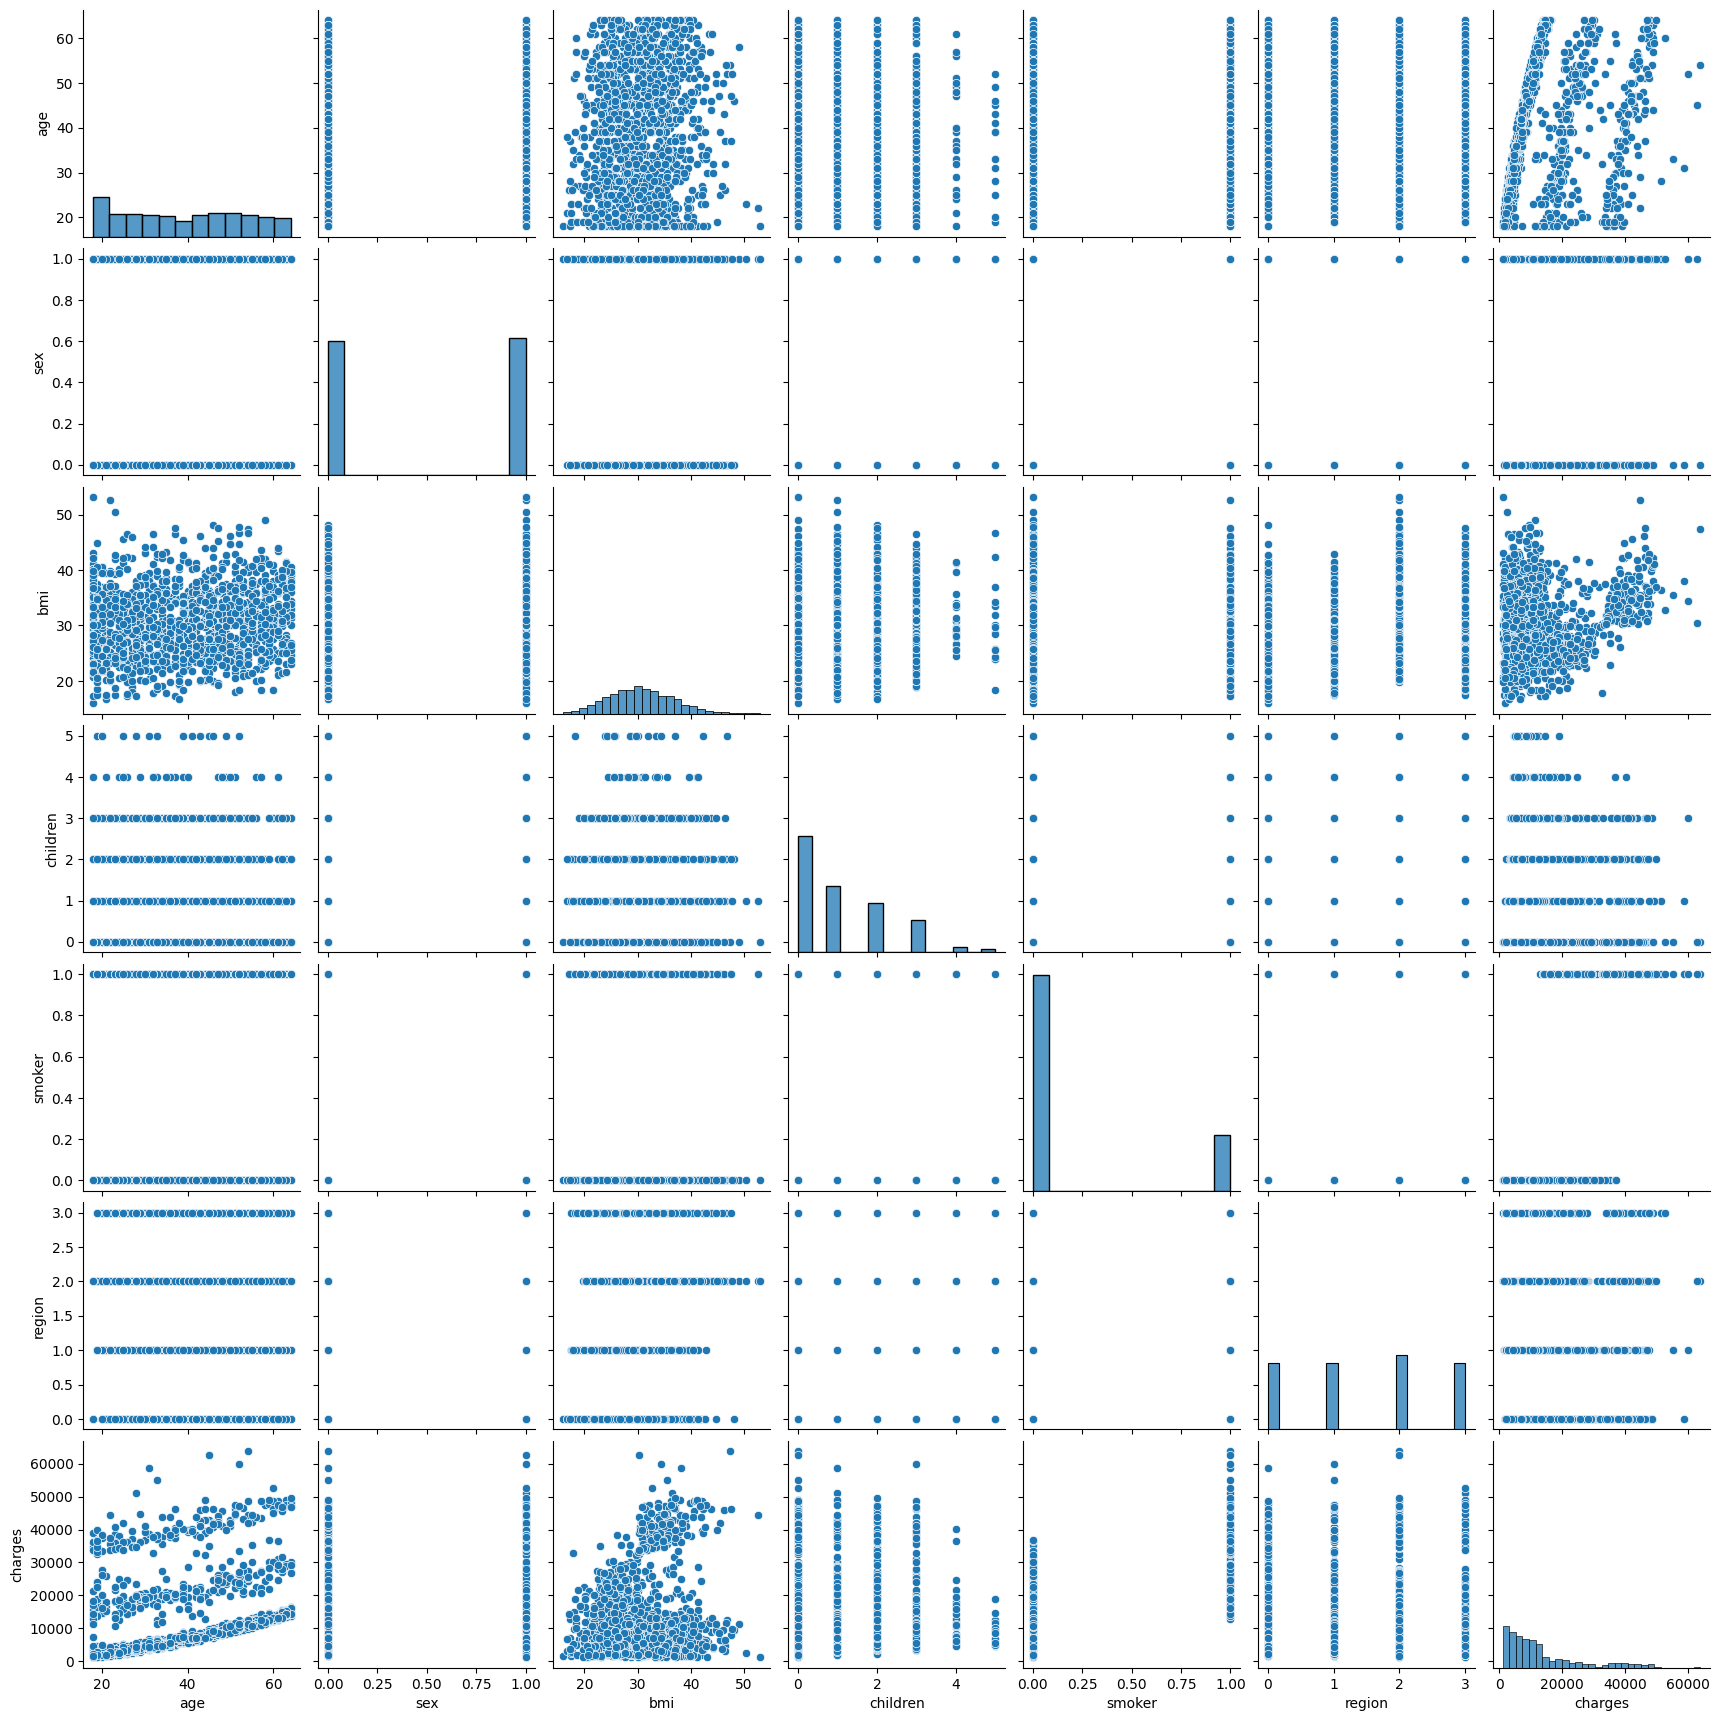

In [ ]:
sns.pairplot(data)
plt.show()

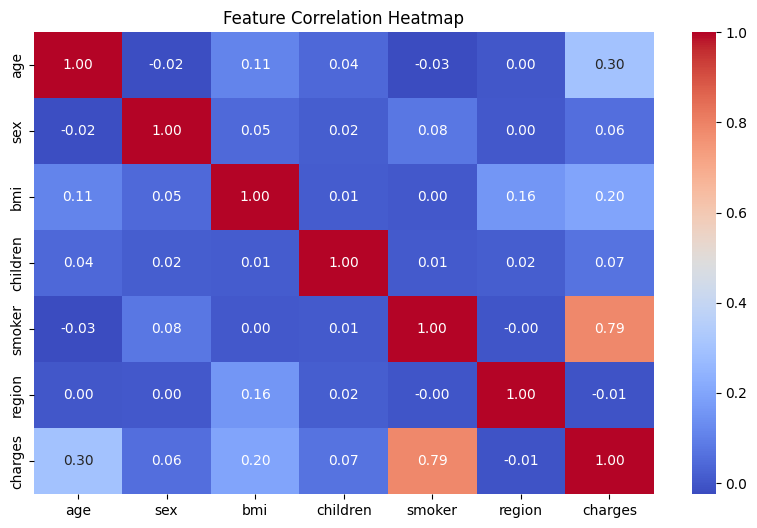

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

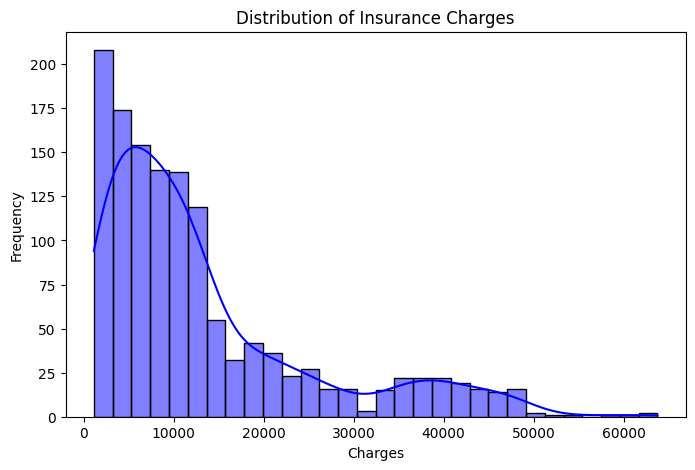

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data['charges'], bins=30, kde=True, color='blue')
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

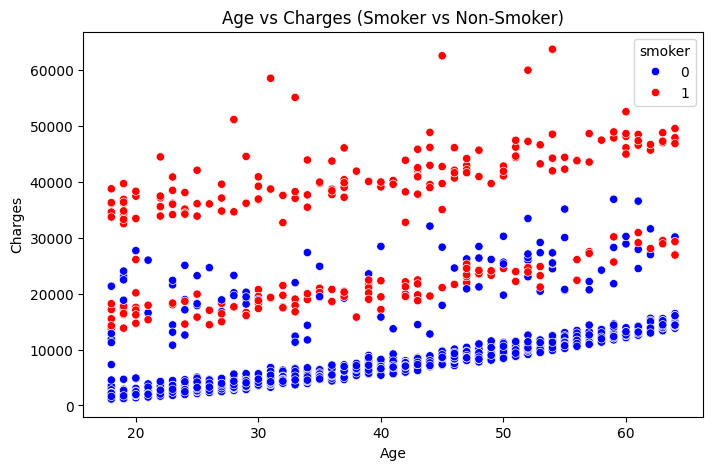

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data['age'], y=data['charges'], hue=data['smoker'], palette=["blue", "red"])
plt.title("Age vs Charges (Smoker vs Non-Smoker)")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

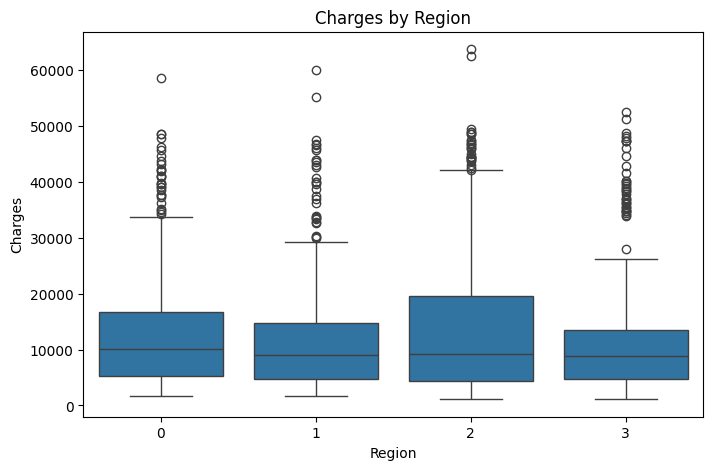

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['region'], y=data['charges'])
plt.title("Charges by Region")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()

In [ ]:
# Models Initialization
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100),
    "SVR": SVR(kernel='rbf'),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100)
}

# Train & Evaluate Models
results = {}
predictions = {}

# Training & Evaluating in Pairs
for (name1, model1), (name2, model2) in zip(list(models.items())[::2], list(models.items())[1::2]):
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)

    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)

    r2_1, rmse_1 = r2_score(y_test, y_pred1), np.sqrt(mean_squared_error(y_test, y_pred1))
    r2_2, rmse_2 = r2_score(y_test, y_pred2), np.sqrt(mean_squared_error(y_test, y_pred2))

    results[name1] = (r2_1, rmse_1)
    results[name2] = (r2_2, rmse_2)

    predictions[name1] = y_pred1
    predictions[name2] = y_pred2

    print(f"{name1}: R² Score = {r2_1:.4f}, RMSE = {rmse_1:.4f}")
    print(f"{name2}: R² Score = {r2_2:.4f}, RMSE = {rmse_2:.4f}")
    print("-" * 50)

Linear Regression: R² Score = 0.7833, RMSE = 5799.5871
Decision Tree: R² Score = 0.7289, RMSE = 6487.2327
--------------------------------------------------
Random Forest: R² Score = 0.8654, RMSE = 4570.8083
XGBoost: R² Score = 0.8502, RMSE = 4822.9912
--------------------------------------------------
SVR: R² Score = -0.0682, RMSE = 12877.8690
Gradient Boosting: R² Score = 0.8781, RMSE = 4350.7317
--------------------------------------------------


In [ ]:
stacked_models = {
    "Stacked (Linear Regression + Decision Tree)": StackingRegressor(
        estimators=[
            ("Linear Regression", LinearRegression()),
            ("Decision Tree", DecisionTreeRegressor())
        ],
        final_estimator=LinearRegression()
    ),

    "Stacked (XGBoost + Random Forest)": StackingRegressor(
        estimators=[
            ("XGBoost", xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)),
            ("Random Forest", RandomForestRegressor(n_estimators=100))
        ],
        final_estimator=LinearRegression()
    ),

    "Stacked (Gradient Boosting + SVR)": StackingRegressor(
        estimators=[
            ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100)),
            ("SVR", SVR(kernel='rbf'))
        ],
        final_estimator=LinearRegression()
    )
}

stacked_results = {}
stacked_predictions = {}

for name, model in stacked_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    stacked_results[name] = (r2, rmse)
    stacked_predictions[name] = y_pred

    print(f"{name}: R² Score = {r2:.4f}, RMSE = {rmse:.4f}")
    print("-" * 50)


Stacked (Linear Regression + Decision Tree): R² Score = 0.8257, RMSE = 5201.2430
--------------------------------------------------
Stacked (XGBoost + Random Forest): R² Score = 0.8691, RMSE = 4508.0171
--------------------------------------------------
Stacked (Gradient Boosting + SVR): R² Score = 0.8782, RMSE = 4348.8239
--------------------------------------------------


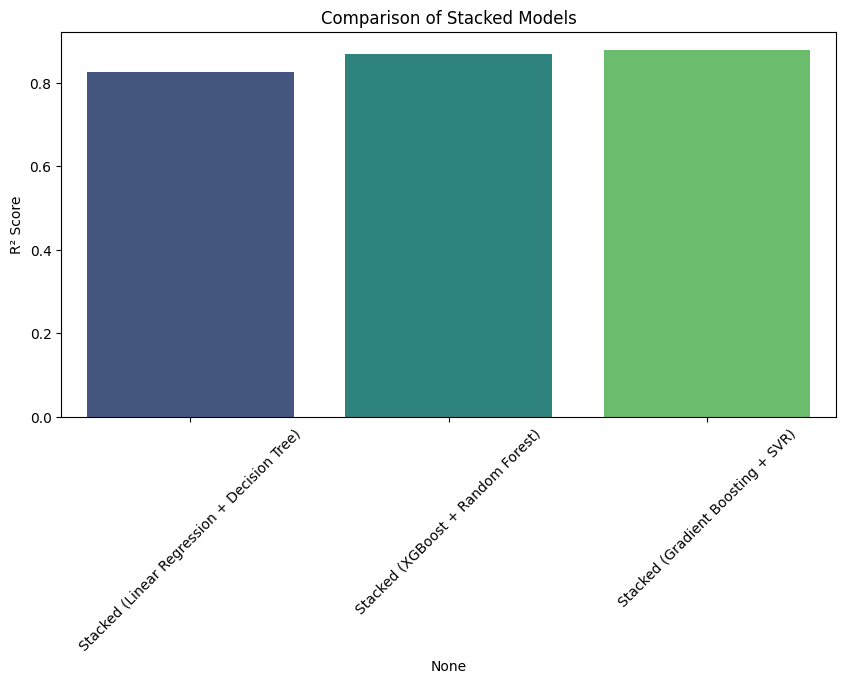

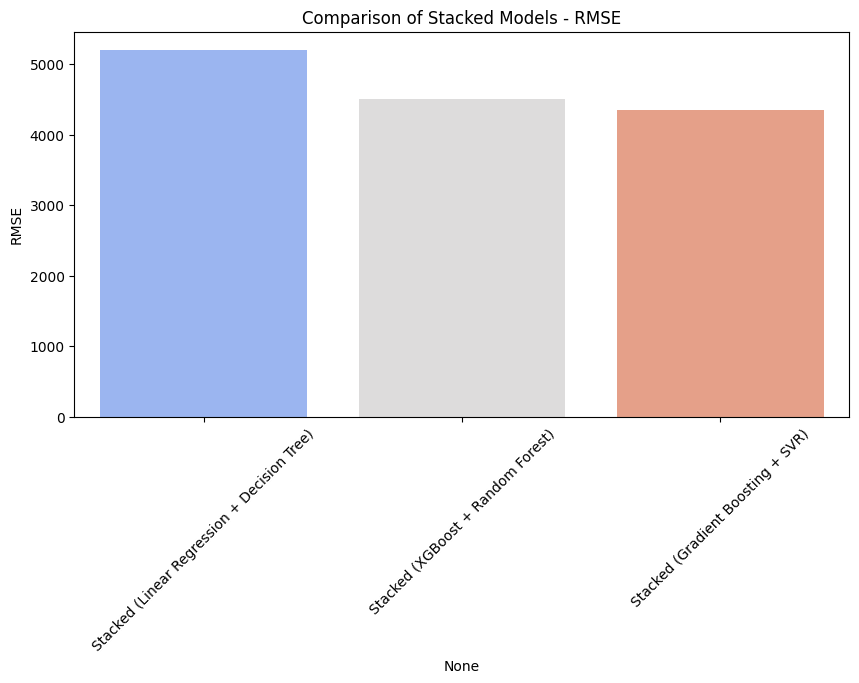

In [ ]:
# Convert stacked results into DataFrame
stacked_results_df = pd.DataFrame(stacked_results, index=["R2 Score", "RMSE"]).T

# Plot Model Performance
plt.figure(figsize=(10, 5))
sns.barplot(x=stacked_results_df.index, y=stacked_results_df['R2 Score'], palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("Comparison of Stacked Models")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=stacked_results_df.index, y=stacked_results_df['RMSE'], palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Comparison of Stacked Models - RMSE")
plt.show()

In [ ]:
# Stacking Model 1
stacked_model_1 = StackingRegressor(
    estimators=[
        ("Linear Regression", LinearRegression()),
        ("Decision Tree", DecisionTreeRegressor()),
        ("Random Forest", RandomForestRegressor(n_estimators=100))
    ],
    final_estimator=LinearRegression()
)

stacked_model_1.fit(X_train, y_train)
y_pred_1 = stacked_model_1.predict(X_test)

r2_1 = r2_score(y_test, y_pred_1)
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))

print(f"Stacked Model 1 (Linear Regression + Decision Tree + Random Forest): R² Score = {r2_1:.4f}, RMSE = {rmse_1:.4f}")

Stacked Model 1 (Linear Regression + Decision Tree + Random Forest): R² Score = 0.8737, RMSE = 4428.6403


In [ ]:
# Stacking Model 2
stacked_model_2 = StackingRegressor(
    estimators=[
        ("XGBoost", xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)),
        ("Random Forest", RandomForestRegressor(n_estimators=100)),
        ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100))
    ],
    final_estimator=LinearRegression()
)

stacked_model_2.fit(X_train, y_train)
y_pred_2 = stacked_model_2.predict(X_test)

r2_2 = r2_score(y_test, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))

print(f"Stacked Model 2 (XGBoost + Random Forest + Gradient Boosting): R² Score = {r2_2:.4f}, RMSE = {rmse_2:.4f}")

Stacked Model 2 (XGBoost + Random Forest + Gradient Boosting): R² Score = 0.8782, RMSE = 4347.6692


In [ ]:
# Stacking Model 3
stacked_model_3 = StackingRegressor(
    estimators=[
        ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100)),
        ("SVR", SVR(kernel='rbf')),
        ("Decision Tree", DecisionTreeRegressor())
    ],
    final_estimator=LinearRegression()
)

stacked_model_3.fit(X_train, y_train)
y_pred_3 = stacked_model_3.predict(X_test)

r2_3 = r2_score(y_test, y_pred_3)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred_3))

print(f"Stacked Model 3 (Gradient Boosting + SVR + Decision Tree): R² Score = {r2_3:.4f}, RMSE = {rmse_3:.4f}")

Stacked Model 3 (Gradient Boosting + SVR + Decision Tree): R² Score = 0.8779, RMSE = 4353.1164


In [ ]:
# Stacking Model 4
stacked_model_4 = StackingRegressor(
    estimators=[
        ("XGBoost", xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)),
        ("SVR", SVR(kernel='rbf')),
        ("Random Forest", RandomForestRegressor(n_estimators=100))
    ],
    final_estimator=LinearRegression()
)

stacked_model_4.fit(X_train, y_train)
y_pred_4 = stacked_model_4.predict(X_test)

r2_4 = r2_score(y_test, y_pred_4)
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred_4))

print(f"Stacked Model 4 (XGBoost + SVR + Random Forest): R² Score = {r2_4:.4f}, RMSE = {rmse_4:.4f}")

Stacked Model 4 (XGBoost + SVR + Random Forest): R² Score = 0.8690, RMSE = 4510.3111


In [ ]:
# Stacking Model 5 (All Models Combined)
stacked_model_5 = StackingRegressor(
    estimators=[
        ("Linear Regression", LinearRegression()),
        ("Decision Tree", DecisionTreeRegressor()),
        ("Random Forest", RandomForestRegressor(n_estimators=100)),
        ("XGBoost", xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)),
        ("SVR", SVR(kernel='rbf')),
        ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100))
    ],
    final_estimator=LinearRegression()
)

stacked_model_5.fit(X_train, y_train)
y_pred_5 = stacked_model_5.predict(X_test)

r2_5 = r2_score(y_test, y_pred_5)
rmse_5 = np.sqrt(mean_squared_error(y_test, y_pred_5))

print(f"Stacked Model 5 (All Models Together): R² Score = {r2_5:.4f}, RMSE = {rmse_5:.4f}")

Stacked Model 5 (All Models Together): R² Score = 0.8810, RMSE = 4297.4952


In [ ]:
stacked_results = {
    "Stacked (LR + DT + RF)": (r2_1, rmse_1),
    "Stacked (XGB + RF + GB)": (r2_2, rmse_2),
    "Stacked (GB + SVR + DT)": (r2_3, rmse_3),
    "Stacked (XGB + SVR + RF)": (r2_4, rmse_4),
    "Stacked (All Models)": (r2_5, rmse_5)
}

# Convert results into a DataFrame
stacked_results_df = pd.DataFrame(stacked_results, index=["R2 Score", "RMSE"]).T

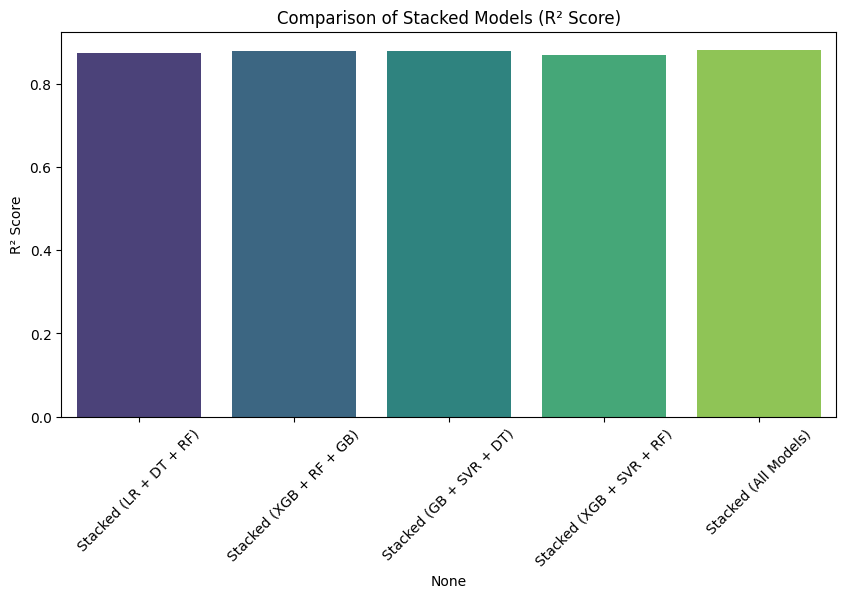

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=stacked_results_df.index, y=stacked_results_df['R2 Score'], palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("Comparison of Stacked Models (R² Score)")
plt.show()

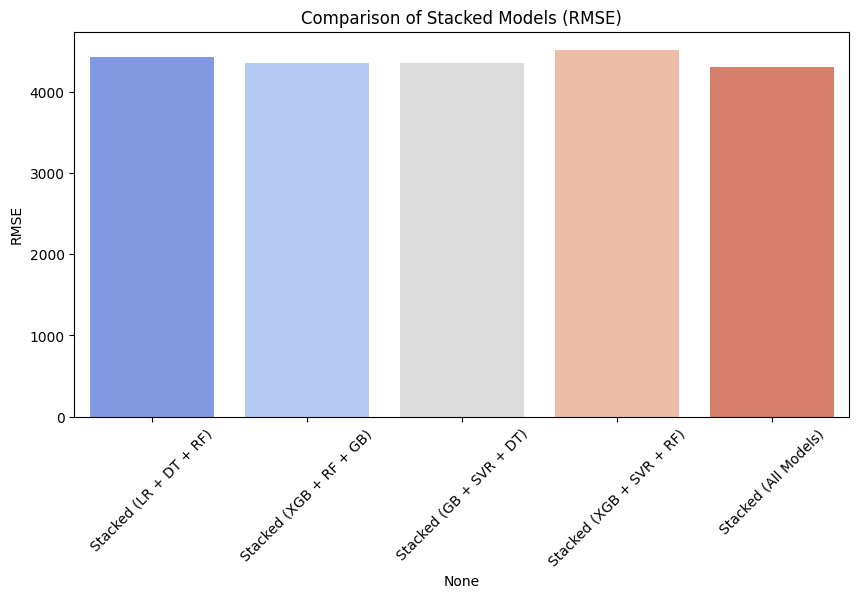

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=stacked_results_df.index, y=stacked_results_df['RMSE'], palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Comparison of Stacked Models (RMSE)")
plt.show()

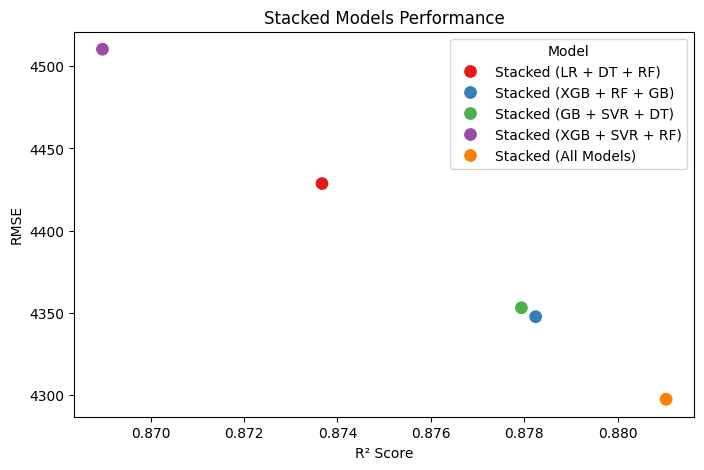

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=stacked_results_df["R2 Score"], y=stacked_results_df["RMSE"], hue=stacked_results_df.index, palette="Set1", s=100)
plt.xlabel("R² Score")
plt.ylabel("RMSE")
plt.title("Stacked Models Performance")
plt.legend(title="Model")
plt.show()

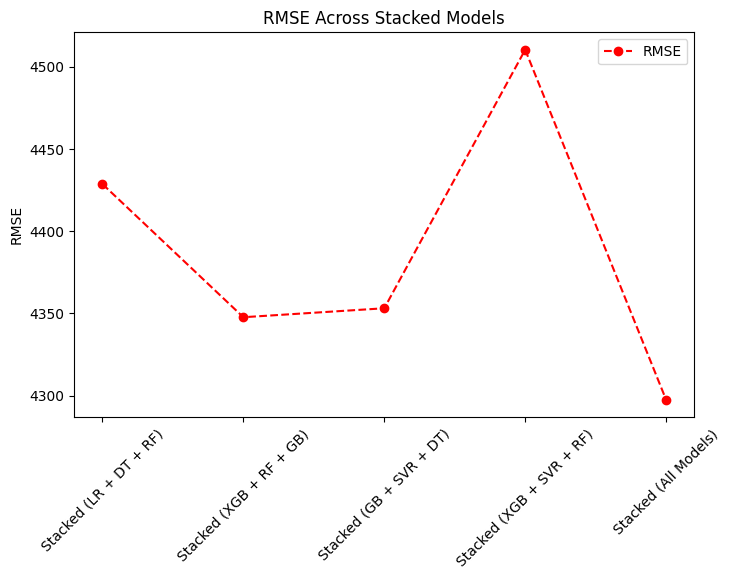

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(stacked_results_df.index, stacked_results_df["RMSE"], marker='o', linestyle='dashed', color='r', label="RMSE")
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("RMSE Across Stacked Models")
plt.legend()
plt.show()

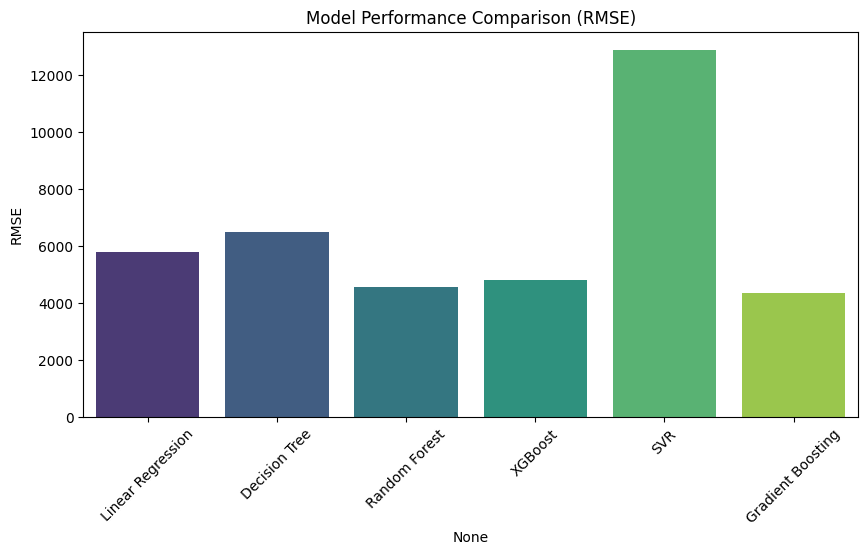

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df['RMSE'], palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Model Performance Comparison (RMSE)")
plt.show()

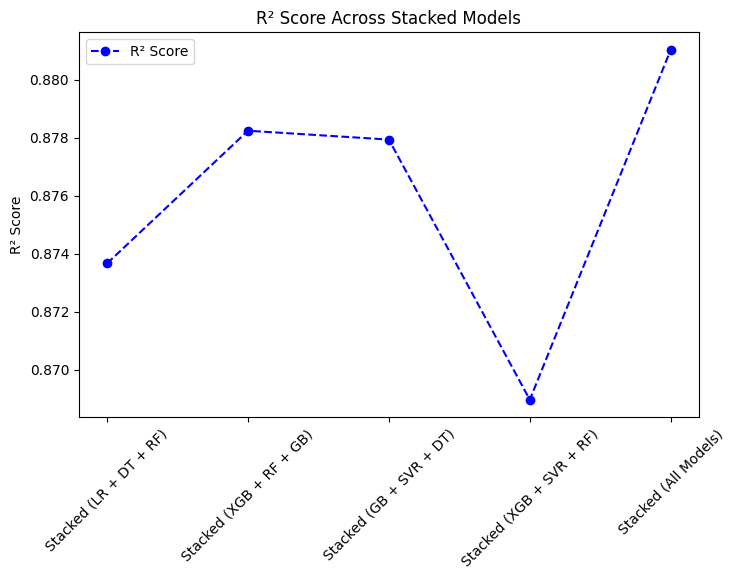

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(stacked_results_df.index, stacked_results_df["R2 Score"], marker='o', linestyle='dashed', color='b', label="R² Score")
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("R² Score Across Stacked Models")
plt.legend()
plt.show()